In [91]:
import numpy as np
from numba import jit

def pairwise_distance(X):
    """
    Returns the pairwise distance matrix for a matrix X using negative squared Euclidean distance.
    """
    sum_X = (X ** 2).sum(axis=1)
    return -np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)

def prob_matrix(dist_X, sigmas):
    """
    Returns the matrix of conditional probabilities p_j|i.
    :param dist_X: the pairwise distance matrix
    :param sigmas: a vector of sigma values corresponding to each row of the distance matrix
    """
    two_sig_sq = np.asarray(2*np.square(sigmas)).reshape((-1, 1))
    x = dist_X / two_sig_sq
    expx = np.exp(x)

    # Since we do not sum over k = l, we set the diagonals to zero
    np.fill_diagonal(expx, 0.)
    # Avoid division by 0 errors
    expx = expx + 1e-8

    # Calculate Normalized Exponential
    rowsums = expx.sum(axis=1).reshape((-1, 1))
    normalized_exp = expx / rowsums
    return normalized_exp

def perplexity(prob_X):
    """
    Calculates the perplexity of each row of the probability matrix.
    :param prob_X: the conditional probability matrix
    :return: a vector of perplexity values
    """
    entropy = -np.sum(prob_X * np.log2(prob_X), axis=1)
    return 2**entropy

# add jit decorators
pairwise_distance_nb = jit(pairwise_distance, nopython=True, cache=True)
prob_matrix_nb = jit(prob_matrix)
perplexity_nb = jit(perplexity, nopython=True, cache=True)

def binary_search(f, target_perplexity, lower=1e-10, upper=1000, tol=1e-8, max_iter=10000):
    """
    Performs a binary search for the value of sigma that corresponds to the target perplexity.
    :param f: function to calculate perplexity
    :param target_perplexity: the specified perplexity value
    :param lower: initial lower bound
    :param upper: initial upper bound
    :param tol: tolerance to determine if the perplexity value is close enough to the target
    :param max_iter: maximum number of iterations of the loop
    :return: the optimal value of sigma
    """
    for i in range(max_iter):
        sigma = (lower + upper) / 2
        perp = f(sigma)
        if abs(perp - target_perplexity) < tol:
            return sigma
        if perp > target_perplexity:
            upper = sigma
        else:
            lower = sigma
    return sigma

def get_sigmas(dist_X, target_perplexity):
    """
    Finds the sigma for each row of the distance matrix based on the target perplexity.
    :param dist_X: the pairwise distance matrix
    :param target_perplexity: the specified perplexity value
    :return: a vector of sigma values corresponding to each row of the distance matrix
    """
    nrows = dist_X.shape[0]
    sigmas = np.zeros(nrows)

    for i in range(nrows):
        f = lambda sigma: perplexity_nb(prob_matrix_nb(dist_X[i:i + 1, :], np.asarray(sigma)))
        best_sigma = binary_search(f, target_perplexity)
        sigmas[i] = best_sigma
    return sigmas

def get_pmatrix(X, perplexity):
    """
    Calculates the final probability matrix using the pairwise affinities/conditional probabilities.
    :param M: the matrix of data to be converted
    :param perplexity: the specified perplexity
    :return: the joint probability matrix p_ij
    """
    # get the pairwise distances
    dist = pairwise_distance_nb(X)
    # get the sigmas
    sigmas = get_sigmas(dist, perplexity)
    # get the matrix of conditional probabilities
    prob = prob_matrix_nb(dist, sigmas)
    p = (prob + prob.T) / (2*prob.shape[0])
    return p

def get_qmatrix(Y):
    """
    Calculates the low dimensional affinities joint matrix q_ij.
    :param Y: low dimensional matrix representation of high dimensional matrix X
    :return: the joint probability matrix q_ij
    """
    q = 1 / (1 - pairwise_distance_nb(Y))
    np.fill_diagonal(q, 0)
    return q / q.sum()

def gradient(P, Q, Y):
    """
    Calculates the gradient of the Kullback-Leibler divergence between P and Q
    :param P: the joint probability matrix
    :param Q: the Student-t based joint probability distribution matrix
    :param Y: low dimensional matrix representation of high dimensional matrix X
    :return: a 2d array of the gradient values with the same dimensions as Y
    """
    pq_diff = np.expand_dims(P - Q, axis=2)
    y_diff = np.expand_dims(Y, axis=1) - np.expand_dims(Y, axis=0)
    dist = 1 - pairwise_distance_nb(Y)
    inv_distance = np.expand_dims(1 / dist, axis=2)

    # multiply and sum over each row
    grad = 4 * (pq_diff * y_diff * inv_distance).sum(axis=1)
    return grad


def TSNE(X, perplexity=40, num_iter=1000, learning_rate=100, momentum_initial=0.5, momentum_final=0.8):
    """
    Performs t-SNE on a given matrix X.
    :param X: matrix of high dimensional data
    :param perplexity: cost function parameter
    :param num_iter: number of iterations
    :param learning_rate: learning rate
    :param momentum_initial: initial momentum for first 250 iterations
    :param momentum_final: final momentum for remaining iterations
    :return: matrix of 2-dimensional data representing X
    """
    # calculate joint probability matrix
    joint_p = get_pmatrix(X, perplexity)
    # early exaggeration to improve optimization
    joint_p = 4 * joint_p

    # initialize Y by sampling from Gaussian
    Y_t = np.random.RandomState(1).normal(0, 10e-4, [X.shape[0], 2])
    # initialize past iteration Y_{t-1}
    Y_t1 = Y_t.copy()
    # initialize past iteration Y_{t-2}
    Y_t2 = Y_t.copy()

    for i in range(num_iter):
        # compute low dimensional affinities matrix
        joint_q = get_qmatrix(Y_t)
        # compute gradient
        grad = gradient(joint_p, joint_q, Y_t)

        # update momentum
        if i < 250:
            momentum = momentum_initial
        else:
            momentum = momentum_final

        # update current Y
        Y_t = Y_t1 - learning_rate * grad + momentum * (Y_t1 - Y_t2)
        # update past iterations
        Y_t1 = Y_t.copy()
        Y_t2 = Y_t1.copy()

        # conclude early exaggeration and revert joint probability matrix back
        if i == 50:
            joint_p = joint_p / 4

    return Y_t

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [26]:
X = np.loadtxt("mnist2500_X.txt")
labels = np.loadtxt("mnist2500_labels.txt")

## Basic TSNE Test (5 Dimensions)

In [114]:
grp1 = np.random.normal(loc=-10, scale=0.25, size=(12, 5))
grp2 = np.random.normal(loc=10, scale=0.25, size=(12, 5))
fake = np.r_[grp1, grp2]
lab = np.concatenate((np.full(12, fill_value = 0), np.full(12, fill_value = 1)), axis=None)

In [115]:
resfake = TSNE(fake, perplexity = 10)

In [116]:
df2 = pd.DataFrame(data=np.c_[resfake, lab], columns=("Coord1", "Coord2", "label"))

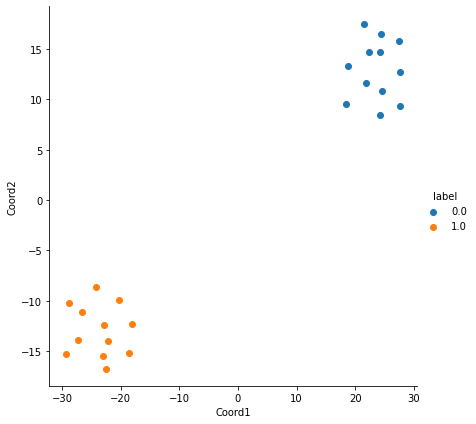

In [117]:
sn.FacetGrid(df2, hue="label", height=6).map(plt.scatter, "Coord1", "Coord2").add_legend()
plt.show()

### Changing the perplexity

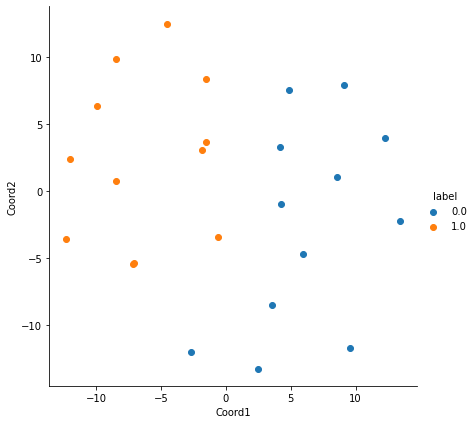

In [123]:
resfake = TSNE(fake, perplexity = 20)
df2 = pd.DataFrame(data=np.c_[resfake, lab], columns=("Coord1", "Coord2", "label"))
sn.FacetGrid(df2, hue="label", height=6).map(plt.scatter, "Coord1", "Coord2").add_legend()
plt.show()

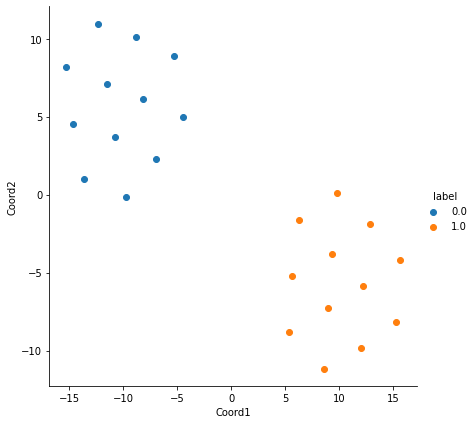

In [124]:
resfake = TSNE(fake, perplexity = 15)
df2 = pd.DataFrame(data=np.c_[resfake, lab], columns=("Coord1", "Coord2", "label"))
sn.FacetGrid(df2, hue="label", height=6).map(plt.scatter, "Coord1", "Coord2").add_legend()
plt.show()

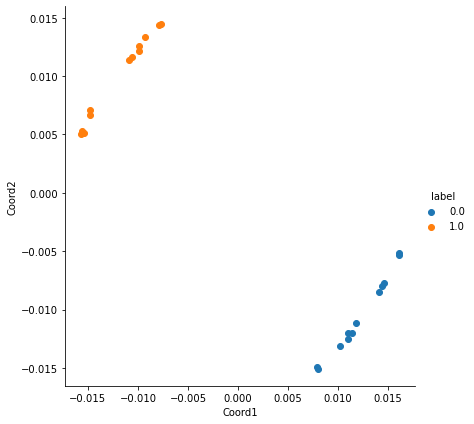

In [125]:
resfake = TSNE(fake, perplexity = 25)
df2 = pd.DataFrame(data=np.c_[resfake, lab], columns=("Coord1", "Coord2", "label"))
sn.FacetGrid(df2, hue="label", height=6).map(plt.scatter, "Coord1", "Coord2").add_legend()
plt.show()

### 3 Dimensions

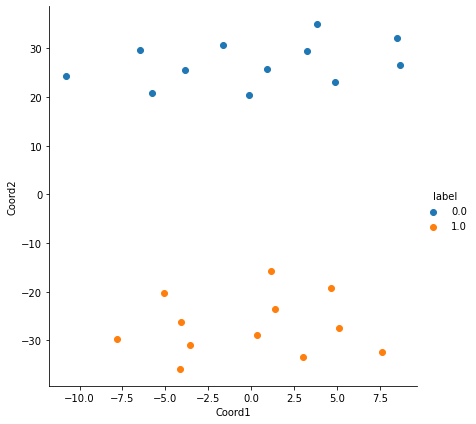

In [130]:
grp1 = np.random.normal(loc=-10, scale=0.25, size=(12, 3))
grp2 = np.random.normal(loc=10, scale=0.25, size=(12, 3))
fake = np.r_[grp1, grp2]
lab = np.concatenate((np.full(12, fill_value = 0), np.full(12, fill_value = 1)), axis=None)
resfake = TSNE(fake, perplexity = 10)
df2 = pd.DataFrame(data=np.c_[resfake, lab], columns=("Coord1", "Coord2", "label"))
sn.FacetGrid(df2, hue="label", height=6).map(plt.scatter, "Coord1", "Coord2").add_legend()
plt.show()

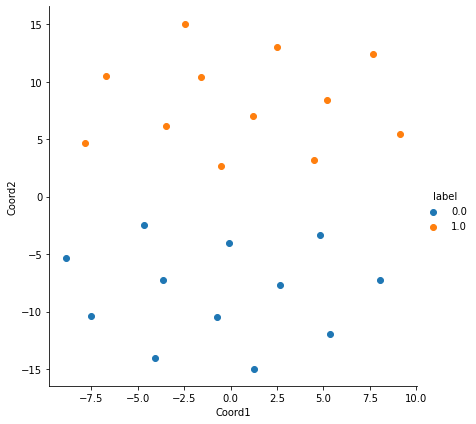

In [129]:
grp1 = np.random.normal(loc=-10, scale=0.25, size=(12, 3))
grp2 = np.random.normal(loc=10, scale=0.25, size=(12, 3))
fake = np.r_[grp1, grp2]
lab = np.concatenate((np.full(12, fill_value = 0), np.full(12, fill_value = 1)), axis=None)
resfake = TSNE(fake, perplexity = 20)
df2 = pd.DataFrame(data=np.c_[resfake, lab], columns=("Coord1", "Coord2", "label"))
sn.FacetGrid(df2, hue="label", height=6).map(plt.scatter, "Coord1", "Coord2").add_legend()
plt.show()

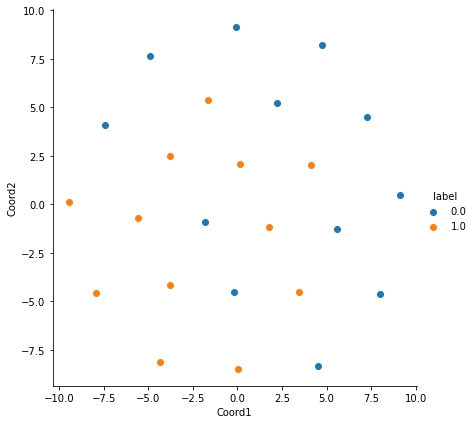

In [128]:
grp1 = np.random.normal(loc=-10, scale=0.25, size=(12, 3))
grp2 = np.random.normal(loc=10, scale=0.25, size=(12, 3))
fake = np.r_[grp1, grp2]
lab = np.concatenate((np.full(12, fill_value = 0), np.full(12, fill_value = 1)), axis=None)
resfake = TSNE(fake, perplexity = 30)
df2 = pd.DataFrame(data=np.c_[resfake, lab], columns=("Coord1", "Coord2", "label"))
sn.FacetGrid(df2, hue="label", height=6).map(plt.scatter, "Coord1", "Coord2").add_legend()
plt.show()

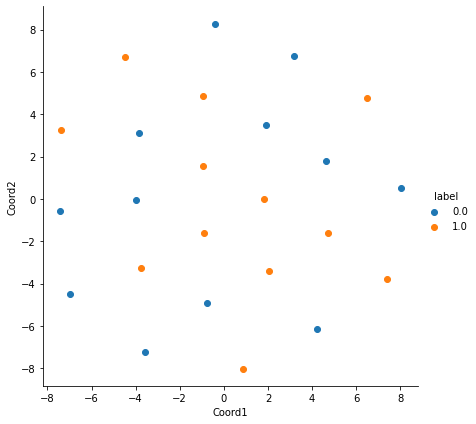

In [131]:
grp1 = np.random.normal(loc=-10, scale=0.25, size=(12, 3))
grp2 = np.random.normal(loc=10, scale=0.25, size=(12, 3))
fake = np.r_[grp1, grp2]
lab = np.concatenate((np.full(12, fill_value = 0), np.full(12, fill_value = 1)), axis=None)
resfake = TSNE(fake, perplexity = 40)
df2 = pd.DataFrame(data=np.c_[resfake, lab], columns=("Coord1", "Coord2", "label"))
sn.FacetGrid(df2, hue="label", height=6).map(plt.scatter, "Coord1", "Coord2").add_legend()
plt.show()